In [1]:
"""Tests for `pydeseq2` package."""

'Tests for `pydeseq2` package.'

In [2]:
import unittest
import ipytest 
import pytest

ipytest.config(rewrite_asserts=True, magics=True)

__file__="pytest_for_deseq2.ipynb"

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/ipytest/_unittest_support.py:18: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as _pd_testing


In [3]:
#python packages
import pydeseq2

import numpy as np
import pandas as pd
import os.path
import os

#rpy2 packages
jupiter_dir="/jupyterminiconda3" #name of the directory in which conda is saved
from pathlib import Path
home = str(Path.home())
os.environ['R_HOME']=os.path.join(home + jupiter_dir + "/envs/pyDESeq2_env/lib/R/")
wd=os.path.join(home, "pydeseq2/tests/data") 

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula

system_file = robjects.r['system.file']
readRDS = robjects.r['readRDS']
rownames=robjects.r['rownames']
colnames=robjects.r['colnames']

In [4]:
##definition of functions to import objects. These functions are not in the package to be more flexible
def importCts(pathCts):
    """imort count matrix as pandas df"""
    cts=pd.read_table(pathCts[0], sep="\t", header=0, index_col=0, dtype="str")
    cts=cts.apply(pd.to_numeric)
    return cts

def importColdata(pathColdata, pathCts):
    """imort sample annotation as pandas df"""
    coldata=pd.read_csv(pathColdata[0],index_col=0) #import coldata information
    coldata.index=coldata.index.str.replace(r'fb$', '')
    coldata=coldata.loc[importCts(pathCts).columns]
    return coldata

cts=importCts(system_file("extdata", "pasilla_gene_counts.tsv", package="pasilla", mustWork=True))
coldata=importColdata(system_file("extdata", "pasilla_sample_annotation.csv", package="pasilla", mustWork=True), system_file("extdata", "pasilla_gene_counts.tsv", package="pasilla", mustWork=True))

##Convert cts and coldata
keep=np.sum(cts,axis=1) >= 10
cts=cts[keep]

##Pre-filtering - not mandatory
r_cts, r_coldata=pydeseq2.pyConvertPandas(cts, coldata)

/mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [5]:
##Load objects
#create dds and rld obj
dds=readRDS(file=os.path.join(wd, 'dds.rds'))
rld=readRDS(file=os.path.join(wd,'rld.rds'))
vsd=readRDS(file=os.path.join(wd,'vsd.rds'))
libSize_df=pd.read_csv(os.path.join(wd,'libsize_table.csv'), index_col=0)

contrast=np.array(['condition','treated', 'untreated']) #set the constrast
res_table=pd.read_csv(os.path.join(wd,'res_table.csv'), index_col=0)
res_table.index.name=None

res, res_df=pydeseq2.pyresults(dds, contrast=contrast)

TCcmap={'untreated:single-read': '#66c2a5','untreated:paired-end': '#fc8d62', 'treated:single-read':'#8da0cb', 'treated:paired-end':'#e78ac3', #pca
        'treated': '#9a009a','untreated': '#009900', 
        'single-read':'#110AEA','paired-end':'#cc0000'} 

In [6]:
##test class methods with default parameters
class Testpydeseq2(unittest.TestCase):

    def test_convertPandas(self):
        self.r_cts, self.r_coldata=pydeseq2.pyConvertPandas(cts, coldata)
        assert isinstance(self.r_cts, type(r_cts))
        assert isinstance(self.r_coldata, type(r_coldata))
        assert np.array_equal(np.array(self.r_cts[0][0:10]), np.array(r_cts[0][0:10]))
        
    def test_pyDESeqDataSetFromMatrix(self):
        self.data=pydeseq2.pyDESeqDataSetFromMatrix(r_cts, r_coldata, design=Formula("~condition"))
        assert isinstance(self.data, type(dds))
        assert np.array_equal(np.array(colnames(self.data)), np.array(colnames(dds)))
        assert np.array_equal(np.array(rownames(self.data)), np.array(rownames(dds)))
    
    def test_pyrlogTransformation(self):
        self.data=pydeseq2.pyrlogTransformation(dds)
        assert isinstance(self.data, type(rld))
        assert np.array_equal(np.array(colnames(self.data)), np.array(colnames(rld)))
        assert np.array_equal(np.array(rownames(self.data)), np.array(rownames(rld)))
        
    def test_pyrVarStabTionformation(self):
        self.data=pydeseq2.pyrVarStabTionformation(dds)
        assert isinstance(self.data, type(vsd))
        assert np.array_equal(np.array(colnames(self.data)), np.array(colnames(vsd)))
        assert np.array_equal(np.array(rownames(self.data)), np.array(rownames(vsd)))
        
    def test_pyCreateLibSizedf(self):
        self.data=pydeseq2.pyCreateLibSizedf(dds, coldata=coldata)
        assert isinstance(self.data, type(libSize_df))
        assert libSize_df.index.identical(self.data.index)
        
    def test_pyResDifferential(self):
        self.res, self.res_df=pydeseq2.pyresults(dds, contrast=contrast)
        assert isinstance(self.res_df, type(res_table))
        assert res_table.index.identical(self.res_df.index)
        assert res_table.columns.identical(self.res_df.columns)
        
    def test_pyPlotLibSizeFact(self):
        pydeseq2.pyPlotLibSizeFact(libSize_df, save=os.path.join(wd,"libsize_test.png"))
        open(os.path.join(wd,"libsize.png"),"rb").read() == open(os.path.join(wd,"libsize_test.png"),"rb").read()
        
    def test_pyPlotPCA(self):
        pydeseq2.pyPlotPCA(rld, intgroup_name=['type'], save=os.path.join(wd,"pcaPlot_test.png"))
        open(os.path.join(wd,"pcaPlot.png"),"rb").read() == open(os.path.join(wd,"pcaPlot_test.png"),"rb").read()

    def test_pyPlotClustering(self):
        pydeseq2.pyPlotClustering(rld, coldata, save=os.path.join(wd,"clusterPlot_test.png"))
        open(os.path.join(wd,"clusterPlot.png"),"rb").read() == open(os.path.join(wd,"clusterPlot_test.png"),"rb").read()
        
    def test_pyPlotMeannormCount_lg10pval(self):
        pydeseq2.pyPlotMeannormCount_lg10pval(res_df, save=os.path.join(wd,"pyPlotMean_test.png"))
        open(os.path.join(wd,"pyPlotMean.png"),"rb").read() == open(os.path.join(wd,"pyPlotMean_test.png"),"rb").read()
        
    def test_pyPlotFilterNumRej(self):
        pydeseq2.pyPlotFilterNumRej(res, save=os.path.join(wd,"pyPlotFilterNumRej_test.png"))
        open(os.path.join(wd,"pyPlotFilterNumRej.png"),"rb").read() == open(os.path.join(wd,"pyPlotFilterNumRej_test.png"),"rb").read()
    
    def test_pyPlotHistpvalue(self):
        pydeseq2.pyPlotHistpvalue(res, res_df, save=os.path.join(wd,"pyPlotHistpvalue_test.png"))
        open(os.path.join(wd,"pyPlotHistpvalue.png"),"rb").read() == open(os.path.join(wd,"pyPlotHistpvalue_test.png"),"rb").read()
        
    def test_pyPlotMA(self):
        pydeseq2.pyPlotMA(res_df, save=os.path.join(wd,"pyPlotMA_test.png"))
        open(os.path.join(wd,"pyPlotMA.png"),"rb").read() == open(os.path.join(wd,"pyPlotMA_test.png"),"rb").read()
        
    def test_pyPlotVolcano(self):
        pydeseq2.pyPlotVolcano(res_df, save=os.path.join(wd,"pyPlotVolcano_test.png"))
        open(os.path.join(wd,"pyPlotVolcano.png"),"rb").read() == open(os.path.join(wd,"pyPlotVolcano_test.png"),"rb").read()

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-5.4.1, py-1.8.1, pluggy-0.13.1 -- /mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/bin/python
cachedir: .pytest_cache
rootdir: /mnt/home/gervasoni/pydeseq2, inifile: setup.cfg
plugins: cov-2.8.1
collecting ... collected 14 items

pytest_for_deseq2.py::Testpydeseq2::test_convertPandas <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyCreateLibSizedf <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyDESeqDataSetFromMatrix <- tests/<ipython-input-6-db27784e11b8> dds exists and it will be loaded
PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotFilterNumRej <- tests/<ipython-input-6-db27784e11b8> 

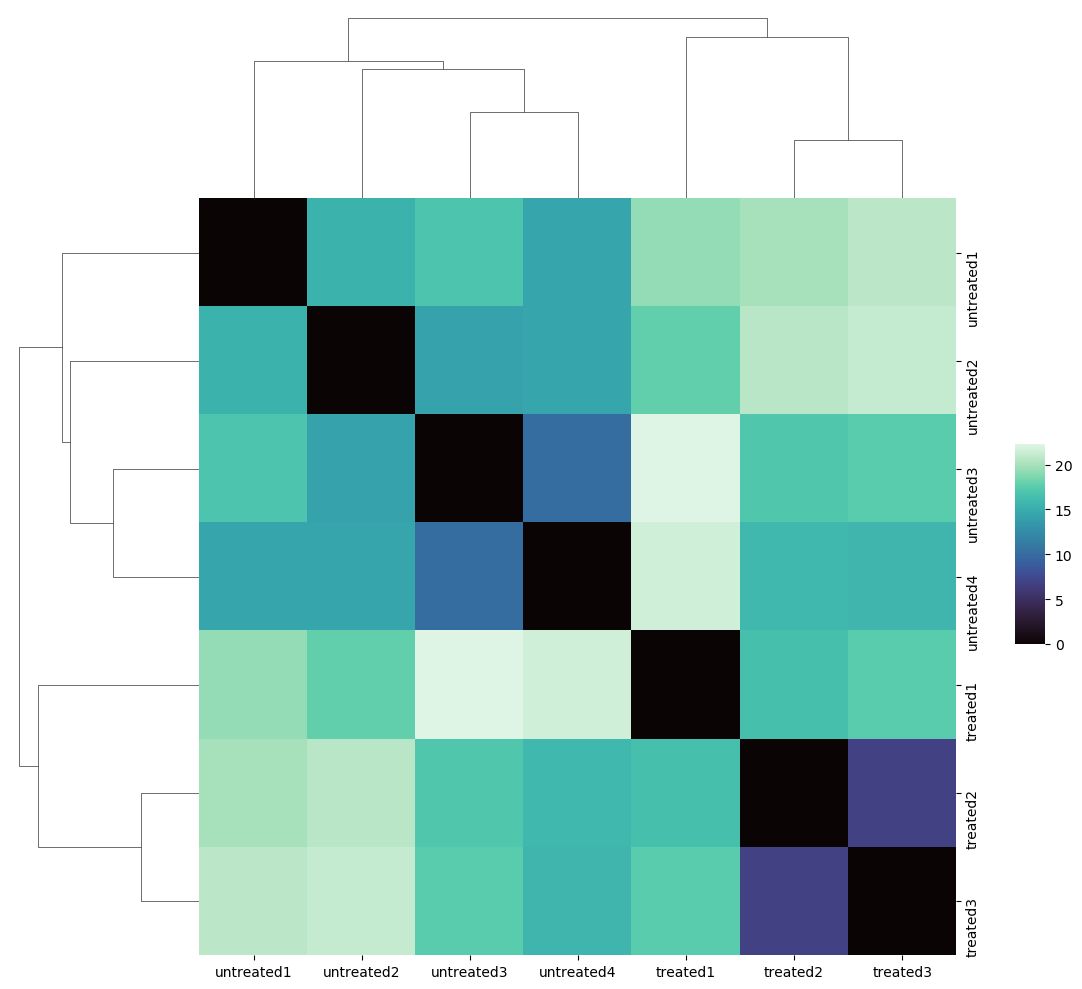

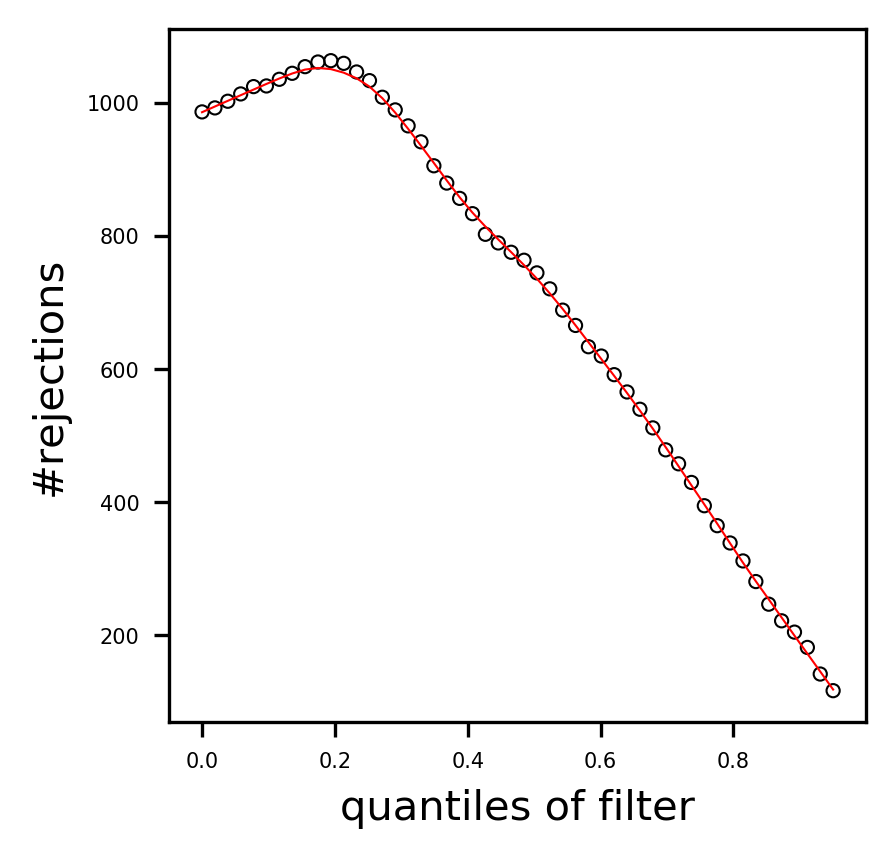

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotHistpvalue <- tests/<ipython-input-6-db27784e11b8> 

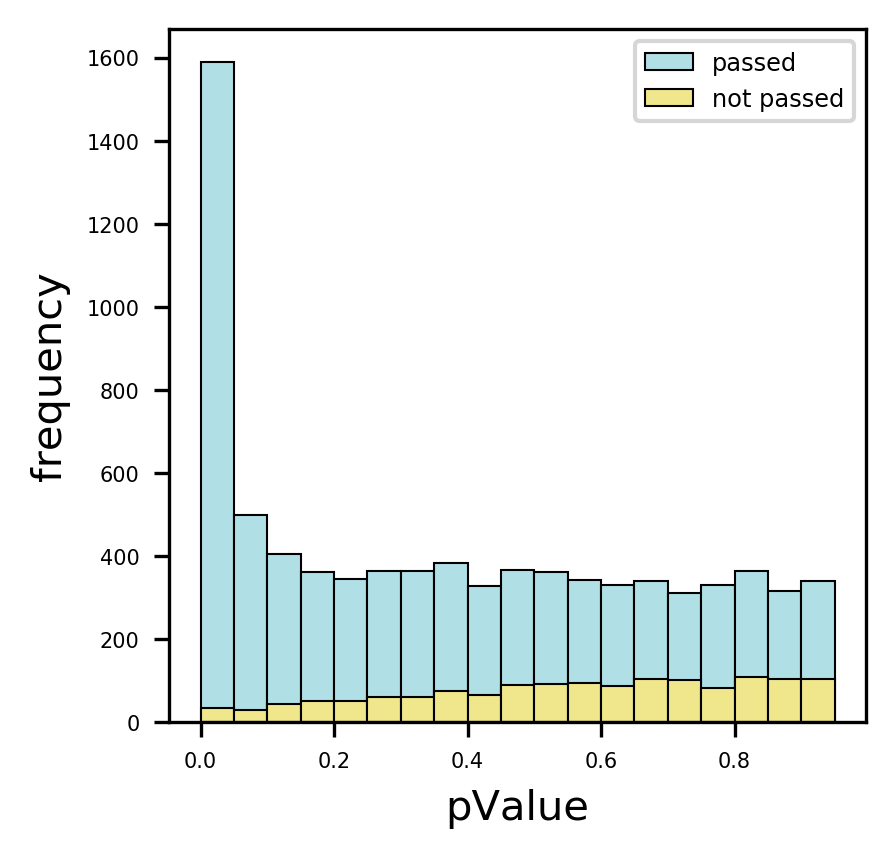

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotLibSizeFact <- tests/<ipython-input-6-db27784e11b8> 

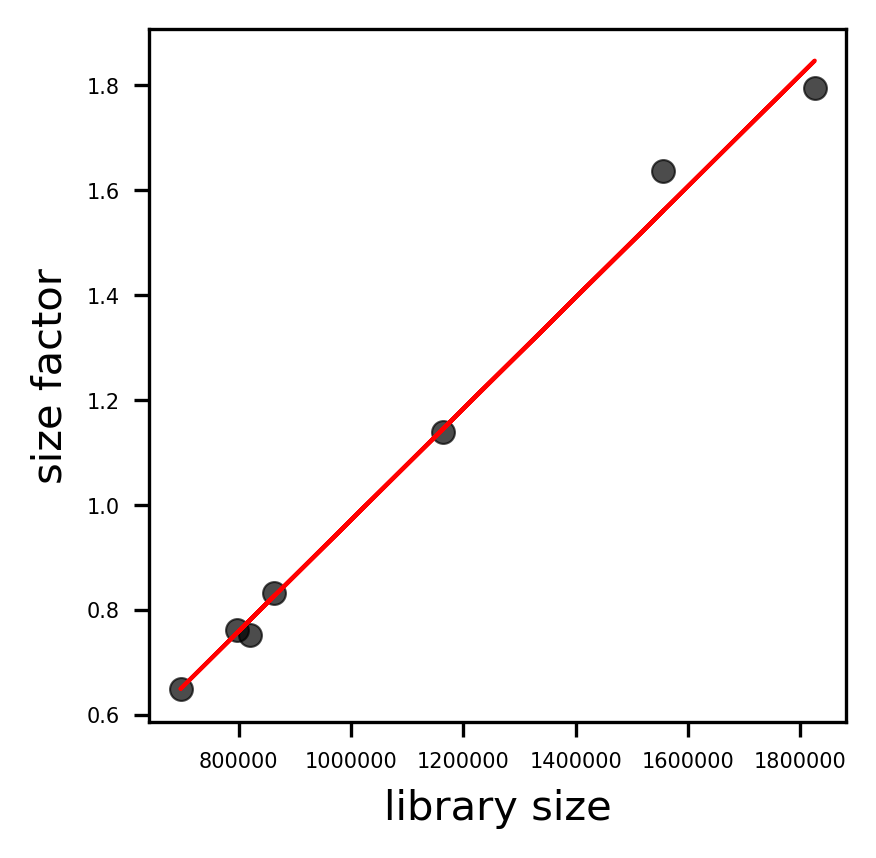

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotMA <- tests/<ipython-input-6-db27784e11b8> 

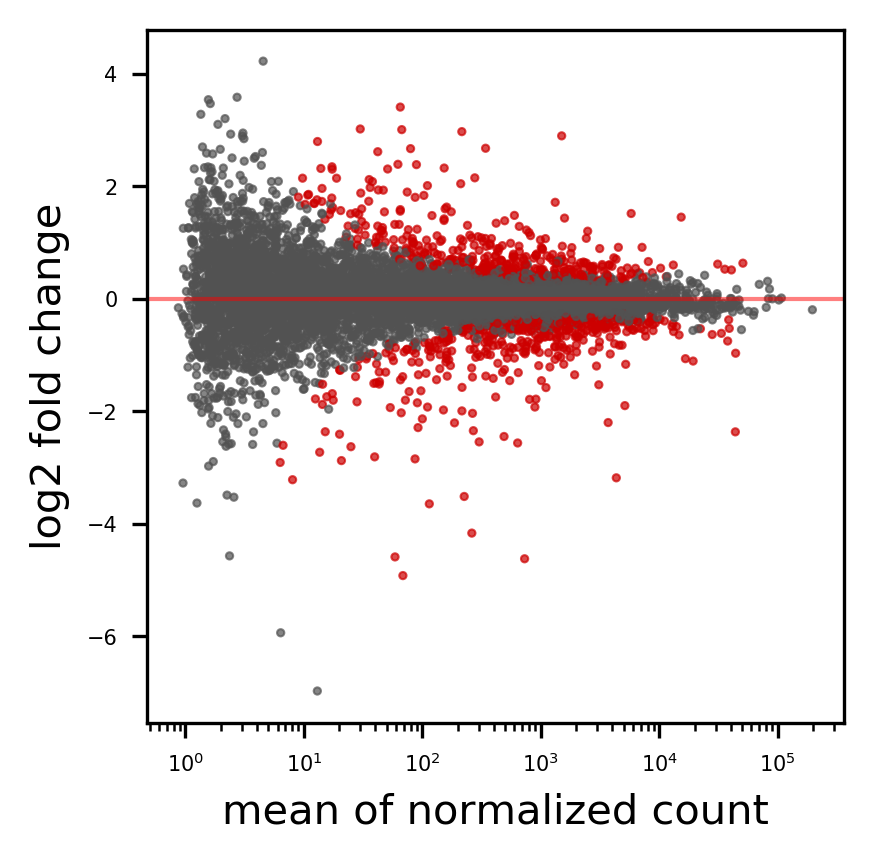

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotMeannormCount_lg10pval <- tests/<ipython-input-6-db27784e11b8> 

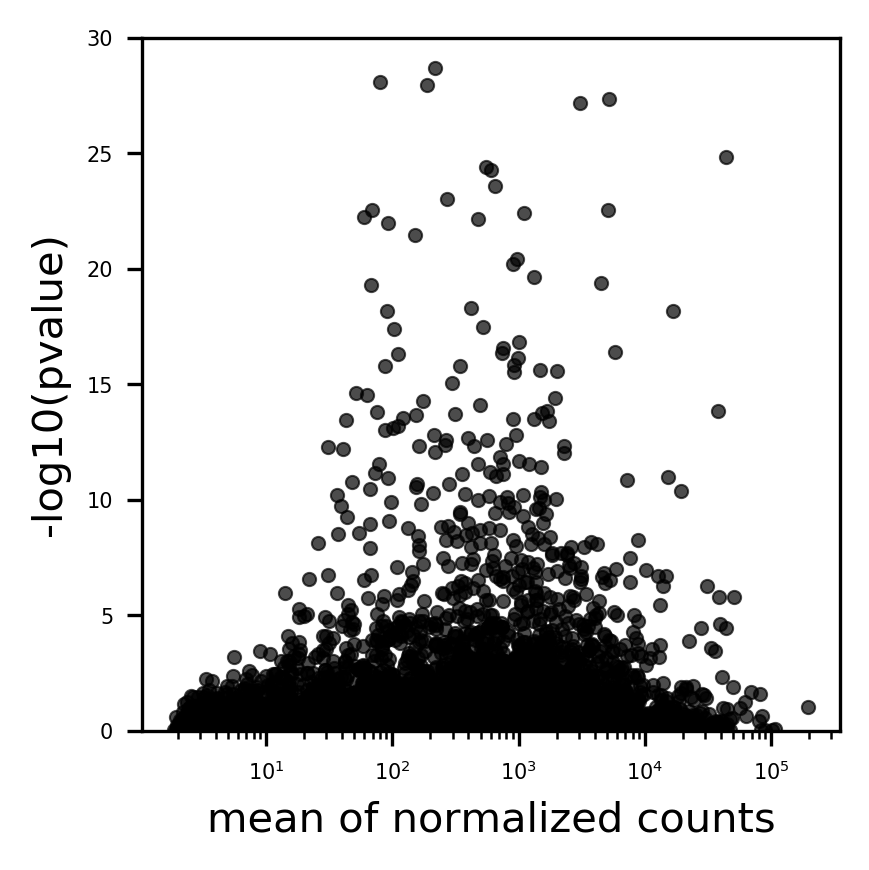

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotPCA <- tests/<ipython-input-6-db27784e11b8> 

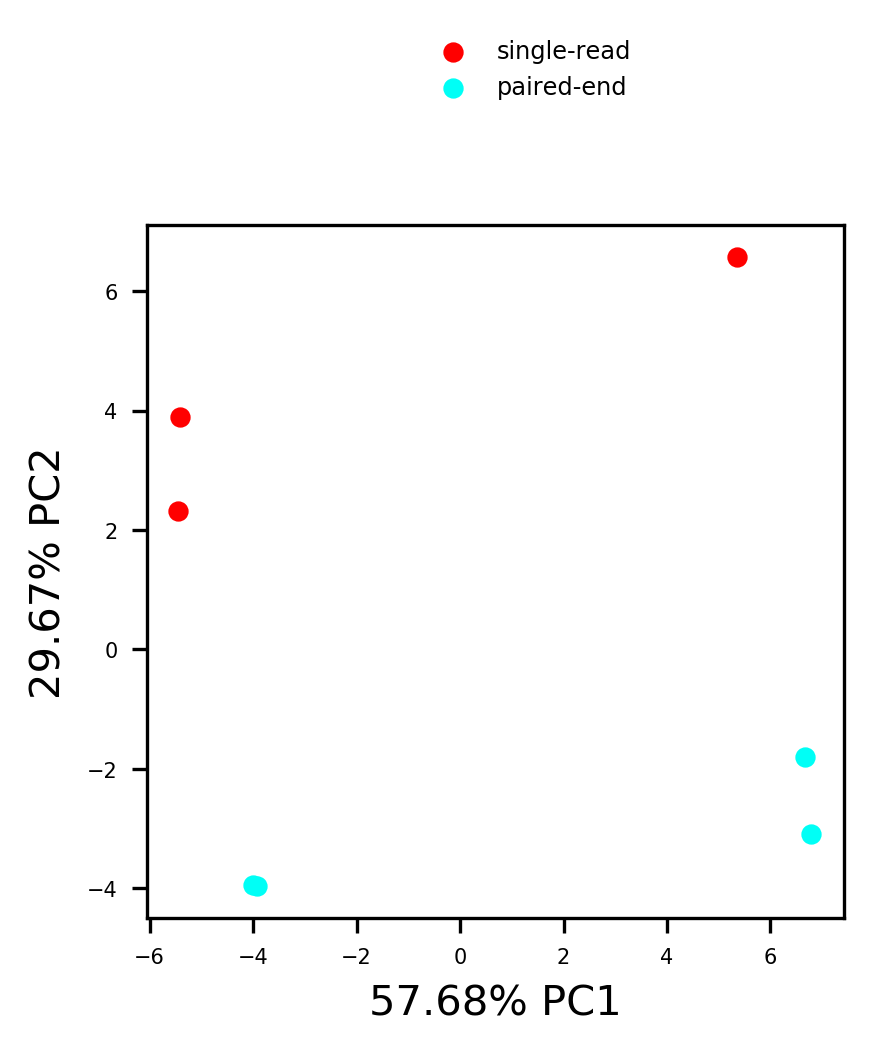

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotVolcano <- tests/<ipython-input-6-db27784e11b8> 

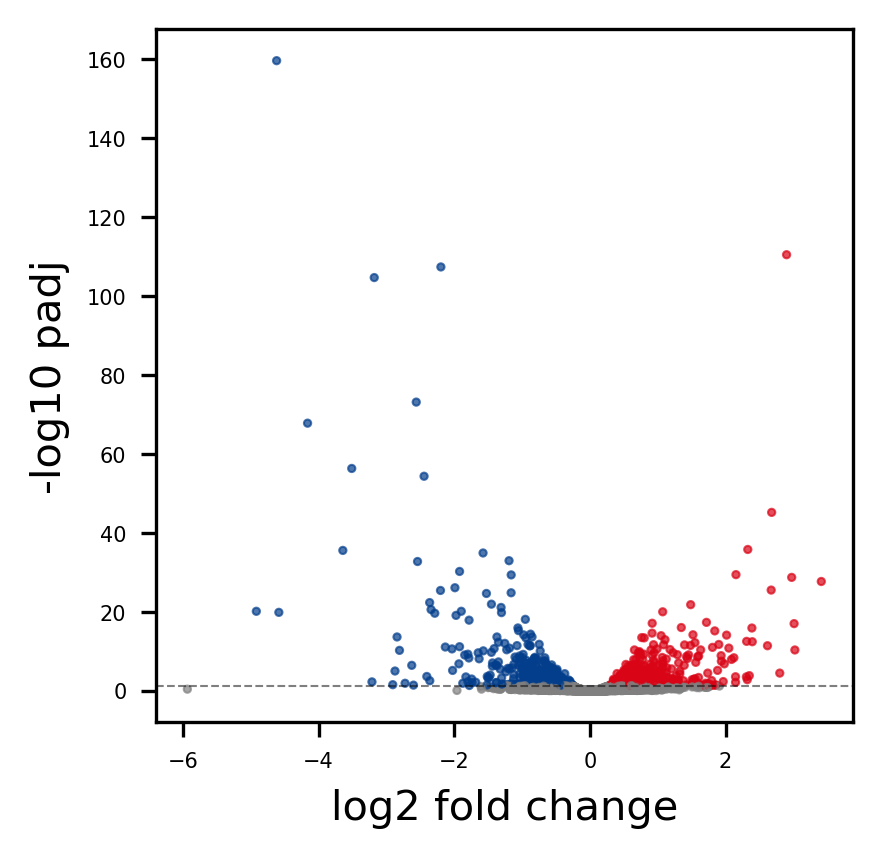

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyResDifferential <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyrVarStabTionformation <- tests/<ipython-input-6-db27784e11b8> vsd exists and it will be loaded
PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyrlogTransformation <- tests/<ipython-input-6-db27784e11b8> rld exists and it will be loaded
PASSED

Coverage.py warning: Module pydeseq2 was previously imported, but not measured (module-not-measured)




=============================== warnings summary ===============================
tests/pytest_for_deseq2.py::Testpydeseq2::test_pyCreateLibSizedf
  /mnt/home/gervasoni/pydeseq2/src/pydeseq2/_utils.py:187: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
    dds_counts=pd.DataFrame(np.matrix(counts(dds)), columns = colnames(dds), index=rownames(dds))

tests/pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering
  /mnt/home/gervasoni/pydeseq2/src/pydeseq2/_plotting.py:288: UserWarning: Warning: You need to set a color condition in intgroup_name field
    warnings.warn("Warning: You need to set a color condition in intgroup_name field")

tests/pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering
  /mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/lib/python3.8/site-packages/seabor

In [7]:
ipytest.run('-svvv')

In [8]:
##test functions with different combination of parameters
@pytest.mark.parametrize("libSize_df, intgroup_name, alpha, s, linewidth, Dictcmap, save", [
    (libSize_df, None, 0.7, 10, 0.3, None, 'save.png'),
    (libSize_df, 'type', 0.7, 3, 3, TCcmap,'save.pdf'),
])
def test_pyPlotLibSizeFact(libSize_df, intgroup_name, alpha, s, linewidth, Dictcmap, save):
    pydeseq2.pyPlotLibSizeFact(libSize_df, intgroup_name, alpha, s, linewidth, Dictcmap, save)


@pytest.mark.parametrize("rld, intgroup_name, n_top, ncompx, ncompy, alpha, s, linewidth, Dictcmap, save", [
    (rld, ['condition'], 500, 1, 2, 0.7, 10, 3, TCcmap, 'save.png'),
    (rld, ['type', 'condition'], 1000, 2, 3, 0.7, 10, 3, None,'save.pdf'),
])
def test_pyPlotPCA(rld, intgroup_name, n_top, ncompx, ncompy, alpha, s, linewidth, Dictcmap, save):
    pydeseq2.pyPlotPCA(rld, intgroup_name, n_top, ncompx, ncompy, alpha, s, linewidth, Dictcmap, save)
    

@pytest.mark.parametrize("rld, coldata, intgroup_name, Dictcmap, save", [
    (rld, coldata, None, None, 'save.png'),
    (rld, coldata, ['type'], None,'save.pdf'),
])
def test_pyPlotClustering(rld, coldata, intgroup_name, Dictcmap, save):
    pydeseq2.pyPlotClustering(rld, coldata, intgroup_name, Dictcmap, save)
    

@pytest.mark.parametrize("res_df, ymax, alpha, s, linewidth, save", [
    (res_df, 30,  0.5, 9, 3, 'save.png'),
    (res_df, 150, 0.9, 3, 0.5, 'save.pdf'),
])
def test_pyPlotMeannormCount_lg10pval(res_df, ymax, alpha, s, linewidth, save):
    pydeseq2.pyPlotMeannormCount_lg10pval(res_df, ymax, alpha, s, linewidth, save)

    
@pytest.mark.parametrize("res, s, linewidth, save", [
    (res, 9, 3, 'save.png'),
    (res, 3, 0.5, 'save.pdf'),
])
def test_pyPlotFilterNumRej(res, s, linewidth, save):
    pydeseq2.pyPlotFilterNumRej(res, s, linewidth, save)
    

@pytest.mark.parametrize("res_df, n_padj, alpha, s, linewidth, ylim, save", [
    (res_df, 0.1, 0.7, 9, 3, 2, 'save.png'),
    (res_df, 0.5, 0.9, 3, 0.5, 4, 'save.pdf'),
])
def test_pyPlotMA(res_df, n_padj, alpha, s, linewidth, ylim, save):
    pydeseq2.pyPlotMA(res_df, n_padj, alpha, s, linewidth, ylim, save)
    

@pytest.mark.parametrize("res_df, n_padj, n_log2FC, alpha, s, linewidth, ylim_max, xlim, a_color, b_color, c_color, save", [
    (res_df, 0.1, 0, 0.7, 9, 3, 2, 2, "#D90416", '#033E8C', 'grey', 'save.png'),
    (res_df, 0.5, 1, 0.9, 3, 0.5, 2, 4, "#D90416", '#033E8C', 'grey', 'save.pdf'),
])
def test_pyPlotVolcano(res_df, n_padj, n_log2FC, alpha, s, linewidth, ylim_max, xlim, a_color, b_color, c_color, save):
    pydeseq2.pyPlotVolcano(res_df, n_padj, n_log2FC, alpha, s, linewidth, ylim_max, xlim, a_color, b_color, c_color, save)

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-5.4.1, py-1.8.1, pluggy-0.13.1 -- /mnt/home/gervasoni/jupyterminiconda3/envs/pyDESeq2_env/bin/python
cachedir: .pytest_cache
rootdir: /mnt/home/gervasoni/pydeseq2, inifile: setup.cfg
plugins: cov-2.8.1
collecting ... collected 28 items

pytest_for_deseq2.py::Testpydeseq2::test_convertPandas <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyCreateLibSizedf <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyDESeqDataSetFromMatrix <- tests/<ipython-input-6-db27784e11b8> dds exists and it will be loaded
PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotFilterNumRej <- tests/<ipython-input-6-db27784e11b8> 

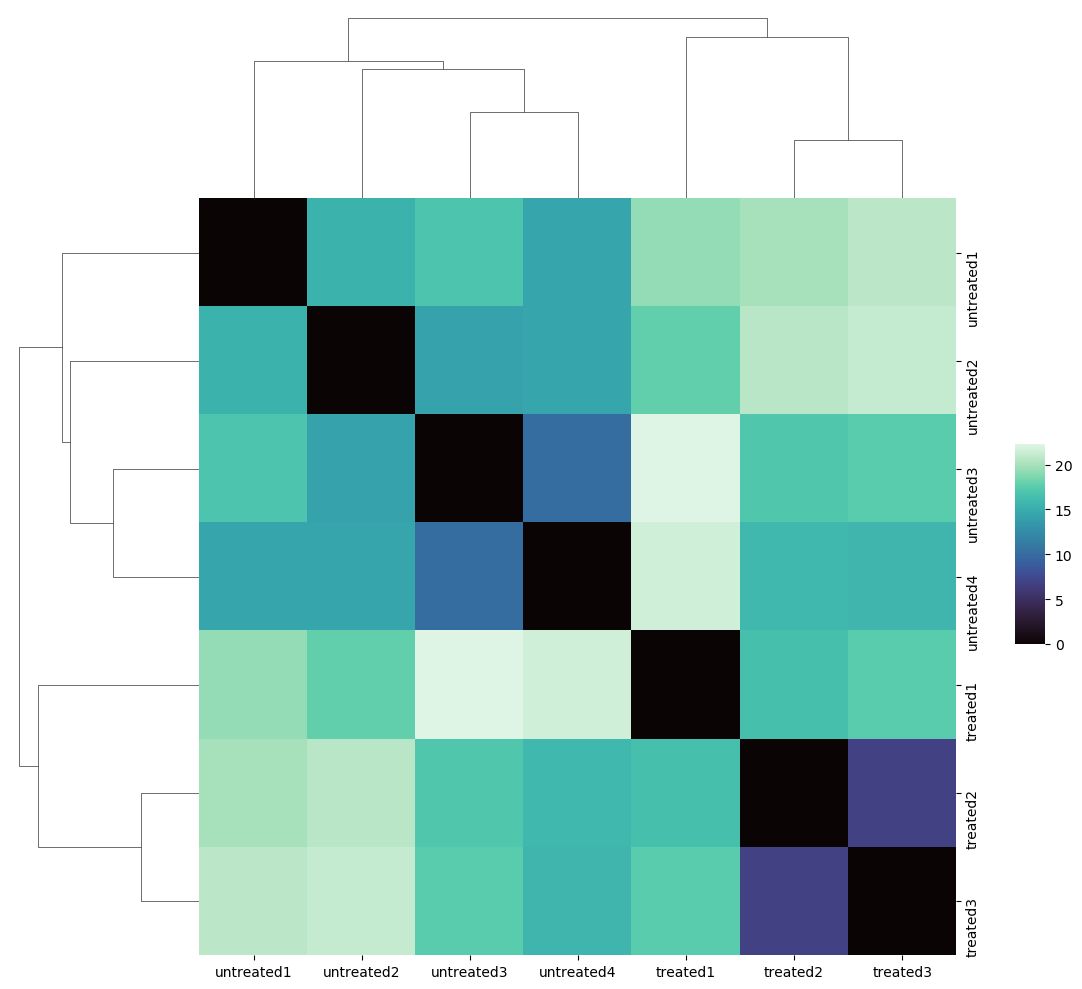

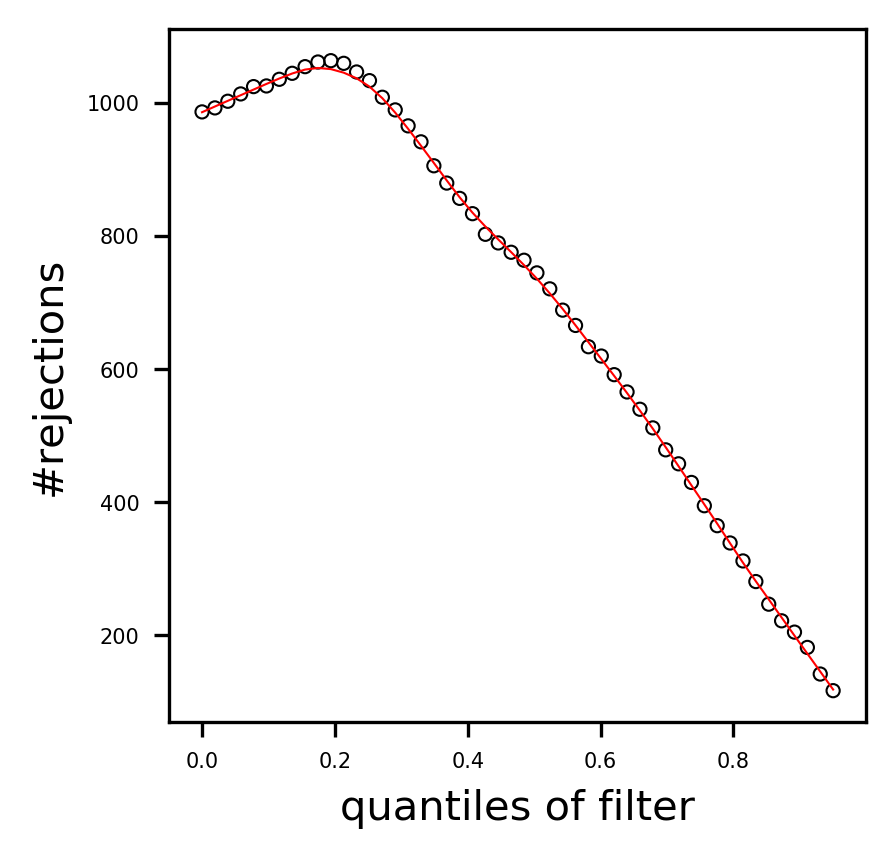

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotHistpvalue <- tests/<ipython-input-6-db27784e11b8> 

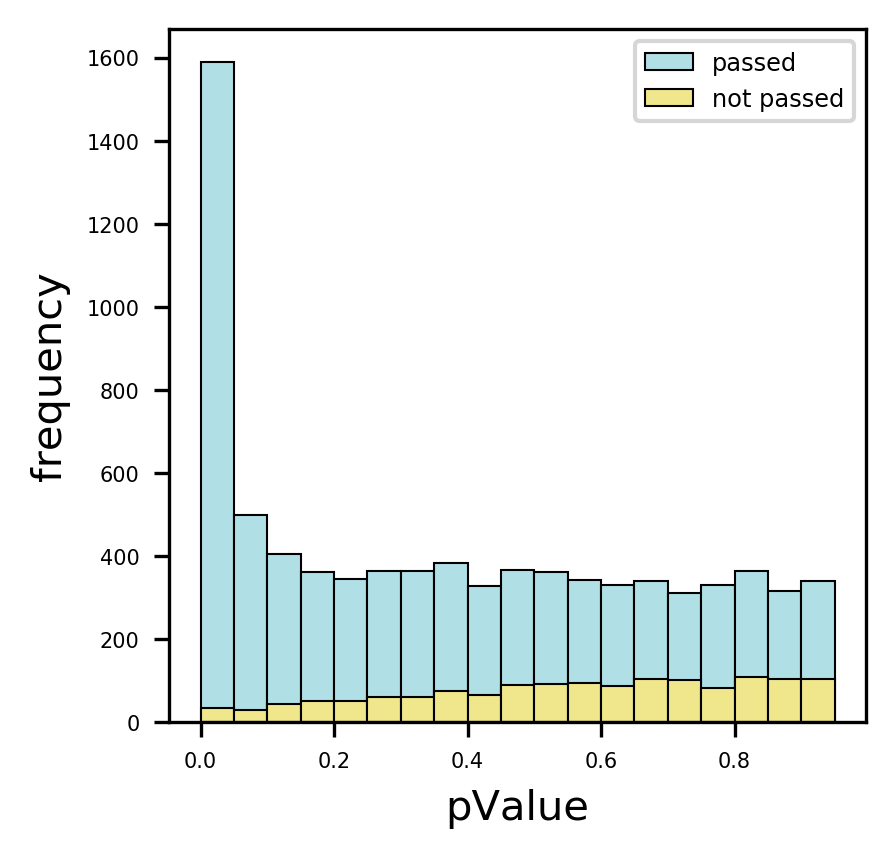

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotLibSizeFact <- tests/<ipython-input-6-db27784e11b8> 

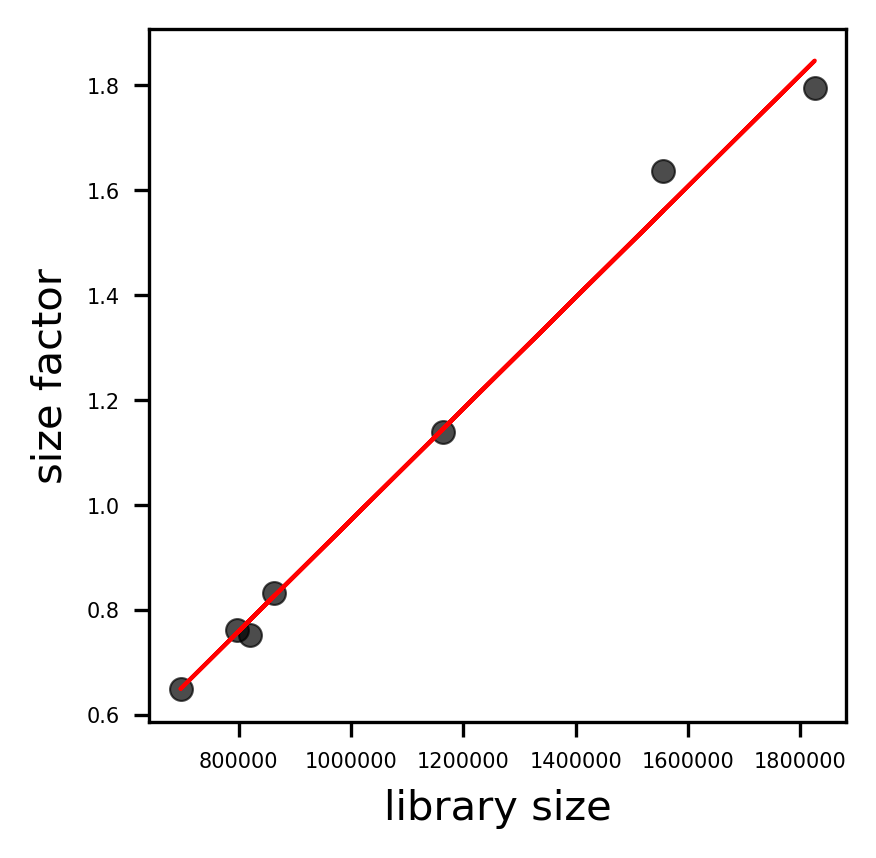

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotMA <- tests/<ipython-input-6-db27784e11b8> 

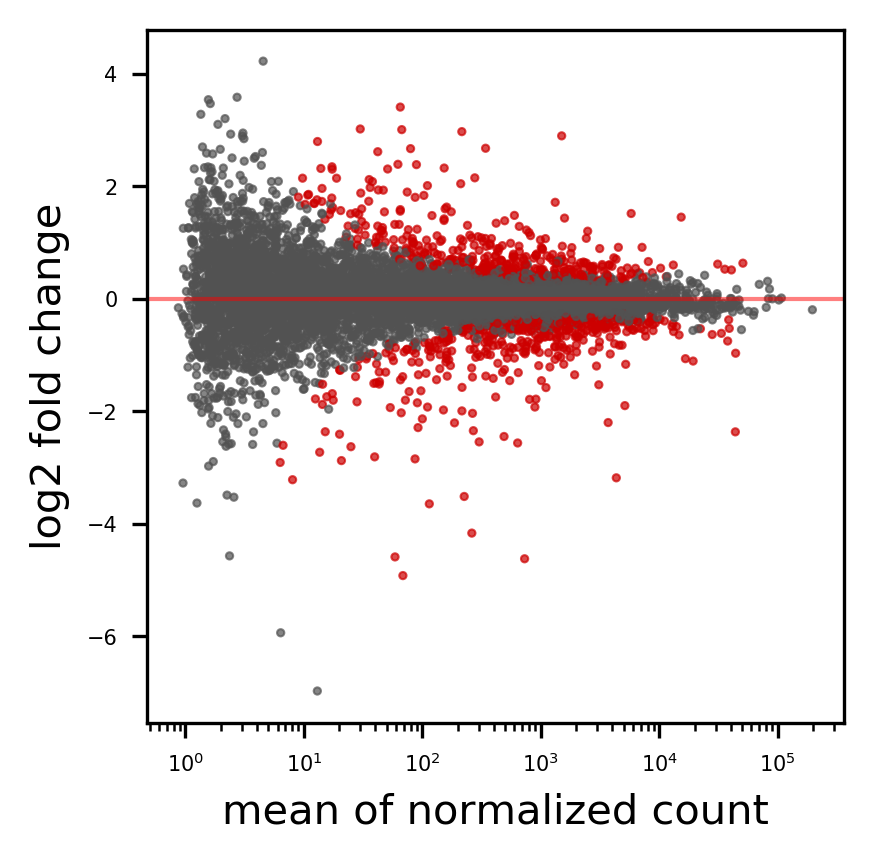

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotMeannormCount_lg10pval <- tests/<ipython-input-6-db27784e11b8> 

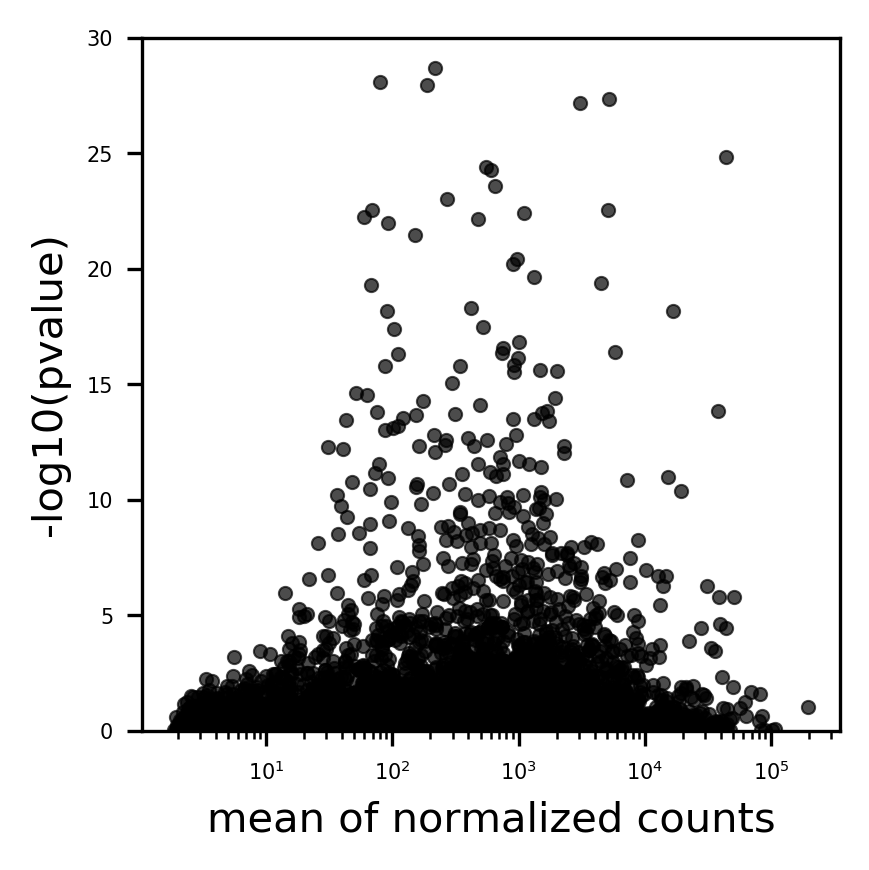

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotPCA <- tests/<ipython-input-6-db27784e11b8> 

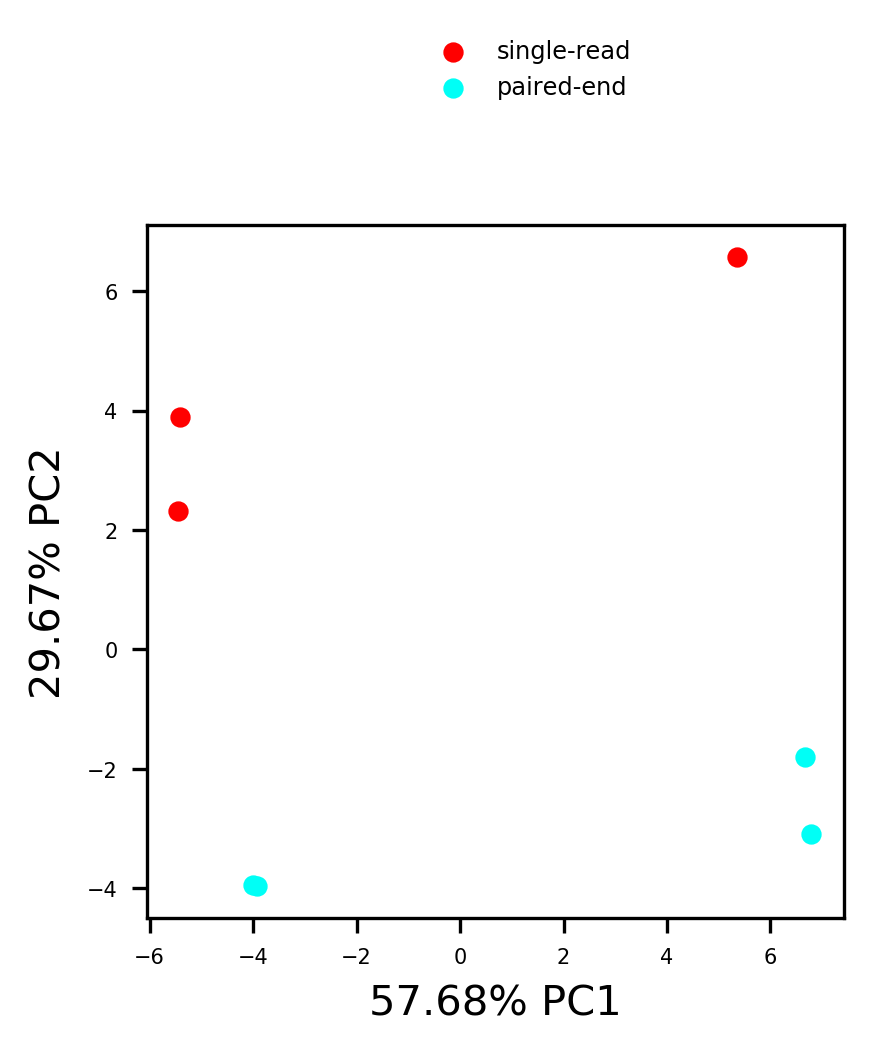

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyPlotVolcano <- tests/<ipython-input-6-db27784e11b8> 

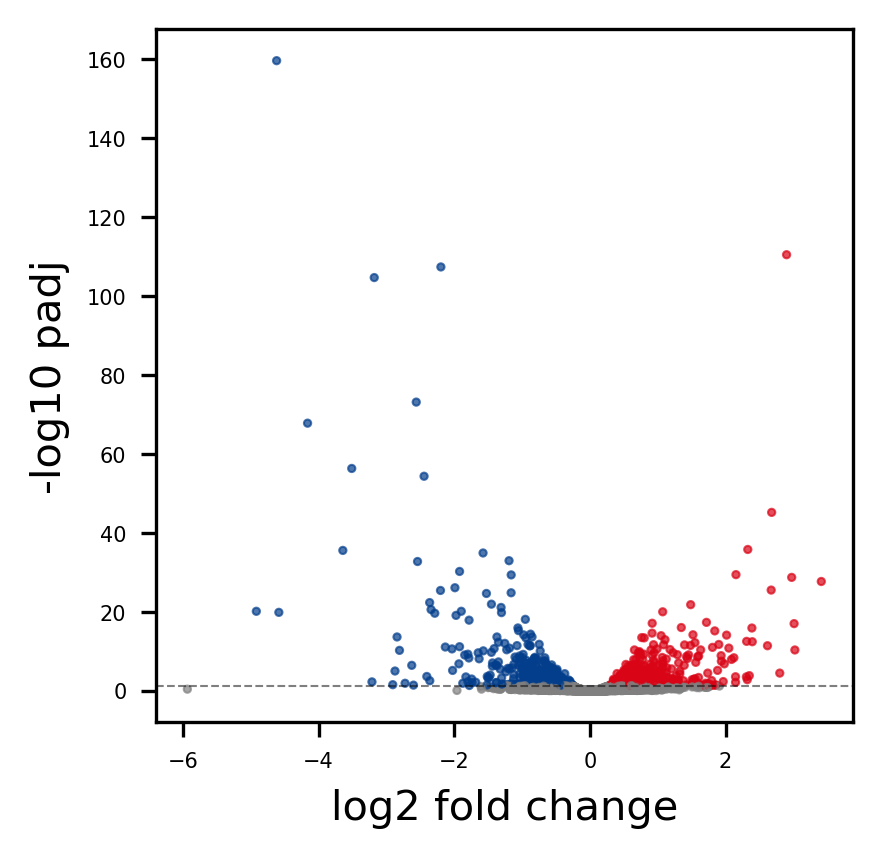

PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyResDifferential <- tests/<ipython-input-6-db27784e11b8> PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyrVarStabTionformation <- tests/<ipython-input-6-db27784e11b8> vsd exists and it will be loaded
PASSED
pytest_for_deseq2.py::Testpydeseq2::test_pyrlogTransformation <- tests/<ipython-input-6-db27784e11b8> rld exists and it will be loaded
PASSED
pytest_for_deseq2.py::test_pyPlotLibSizeFact[libSize_df0-None-0.7-10-0.3-None-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

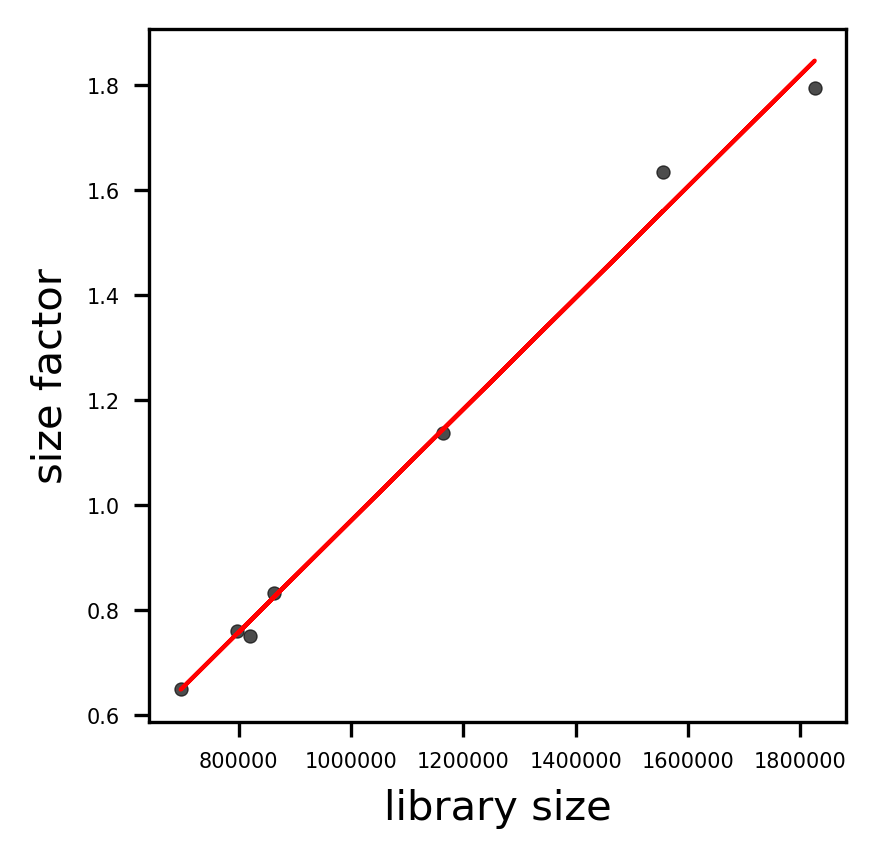

PASSED
pytest_for_deseq2.py::test_pyPlotLibSizeFact[libSize_df1-type-0.7-3-3-Dictcmap1-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

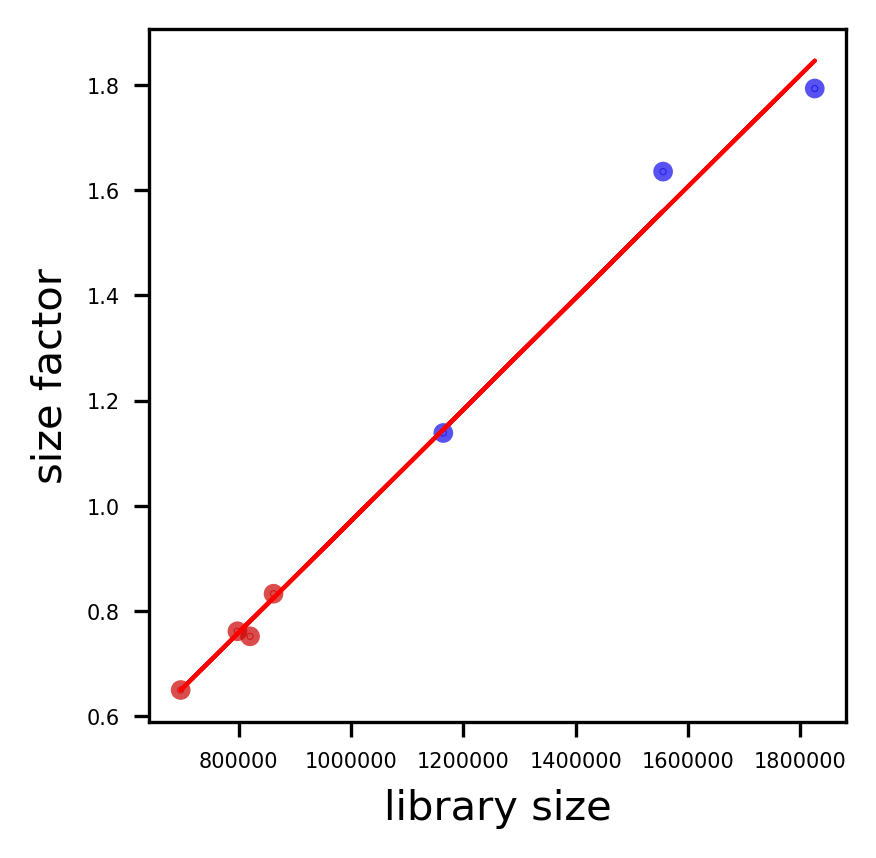

PASSED
pytest_for_deseq2.py::test_pyPlotPCA[rld0-intgroup_name0-500-1-2-0.7-10-3-Dictcmap0-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

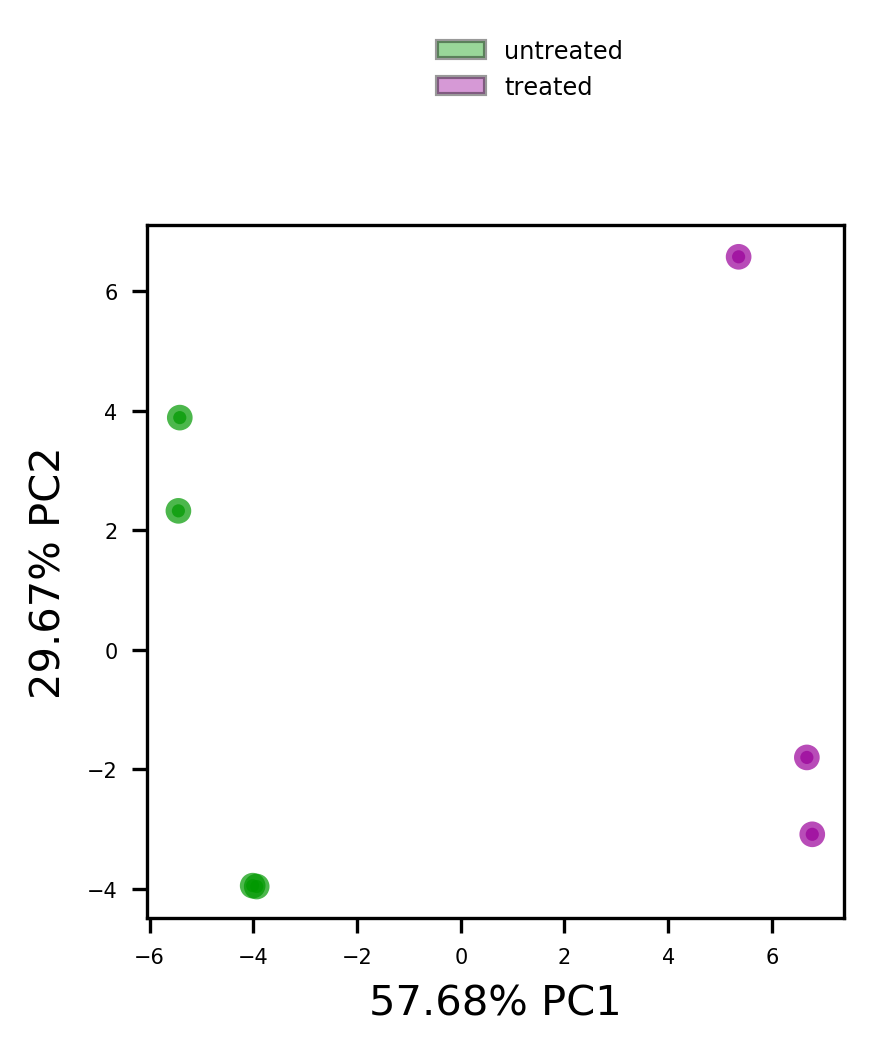

PASSED
pytest_for_deseq2.py::test_pyPlotPCA[rld1-intgroup_name1-1000-2-3-0.7-10-3-None-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

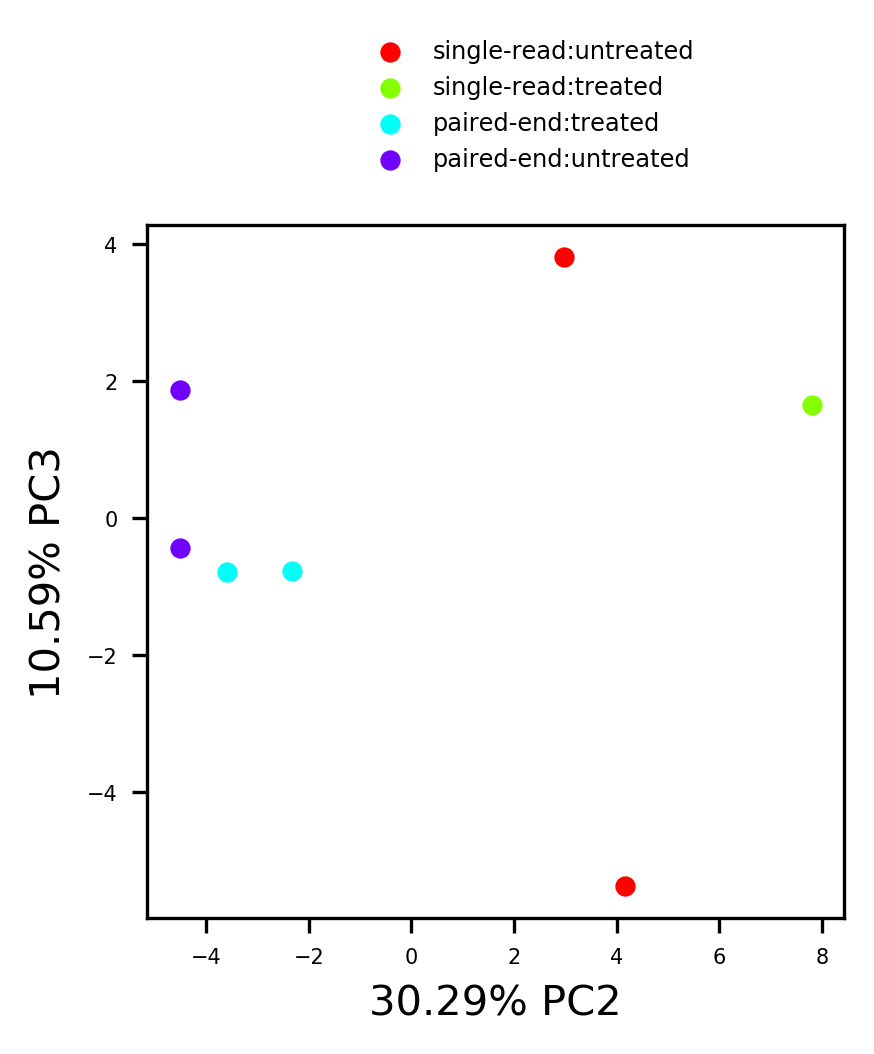

PASSED
pytest_for_deseq2.py::test_pyPlotClustering[rld0-coldata0-None-None-save.png] <- tests/<ipython-input-8-e7f88f2790ef> PASSED
pytest_for_deseq2.py::test_pyPlotClustering[rld1-coldata1-intgroup_name1-None-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> PASSED
pytest_for_deseq2.py::test_pyPlotMeannormCount_lg10pval[res_df0-30-0.5-9-3-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

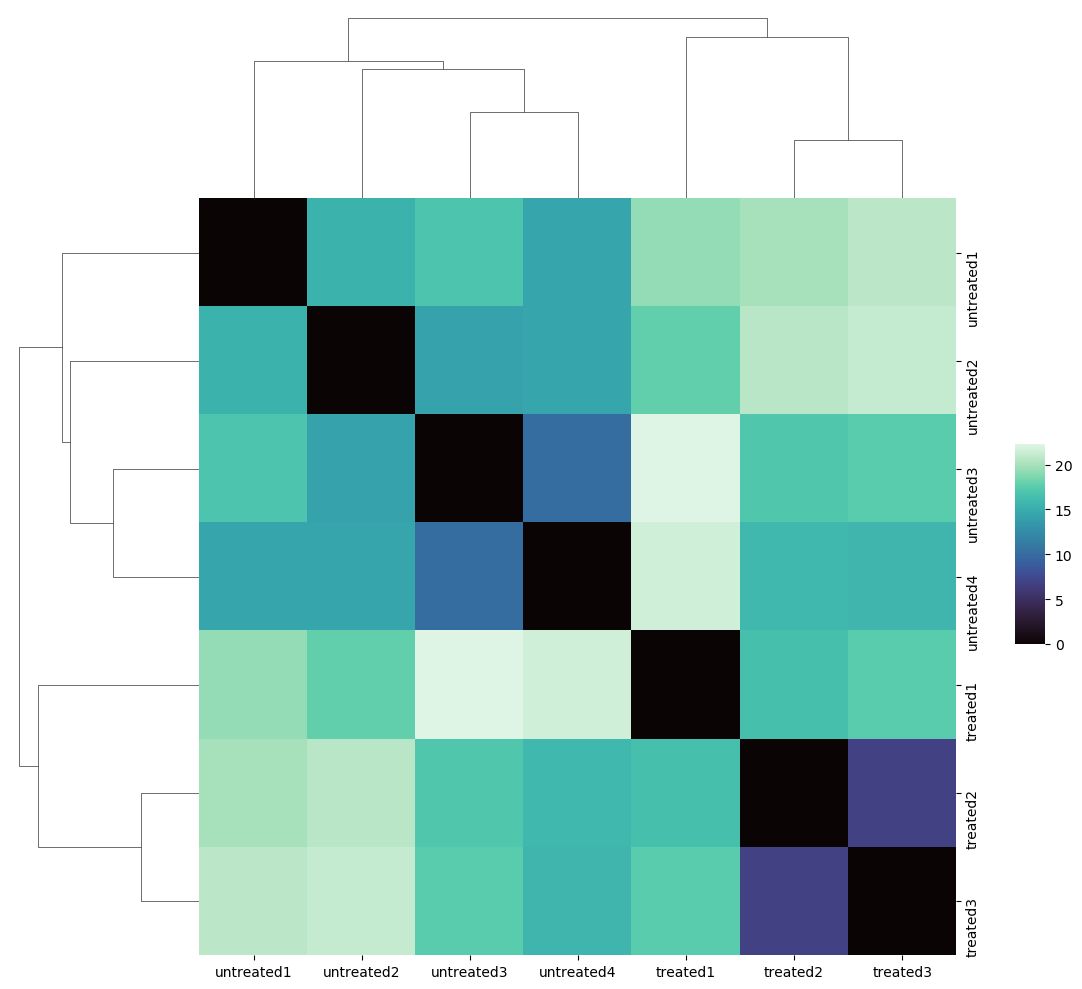

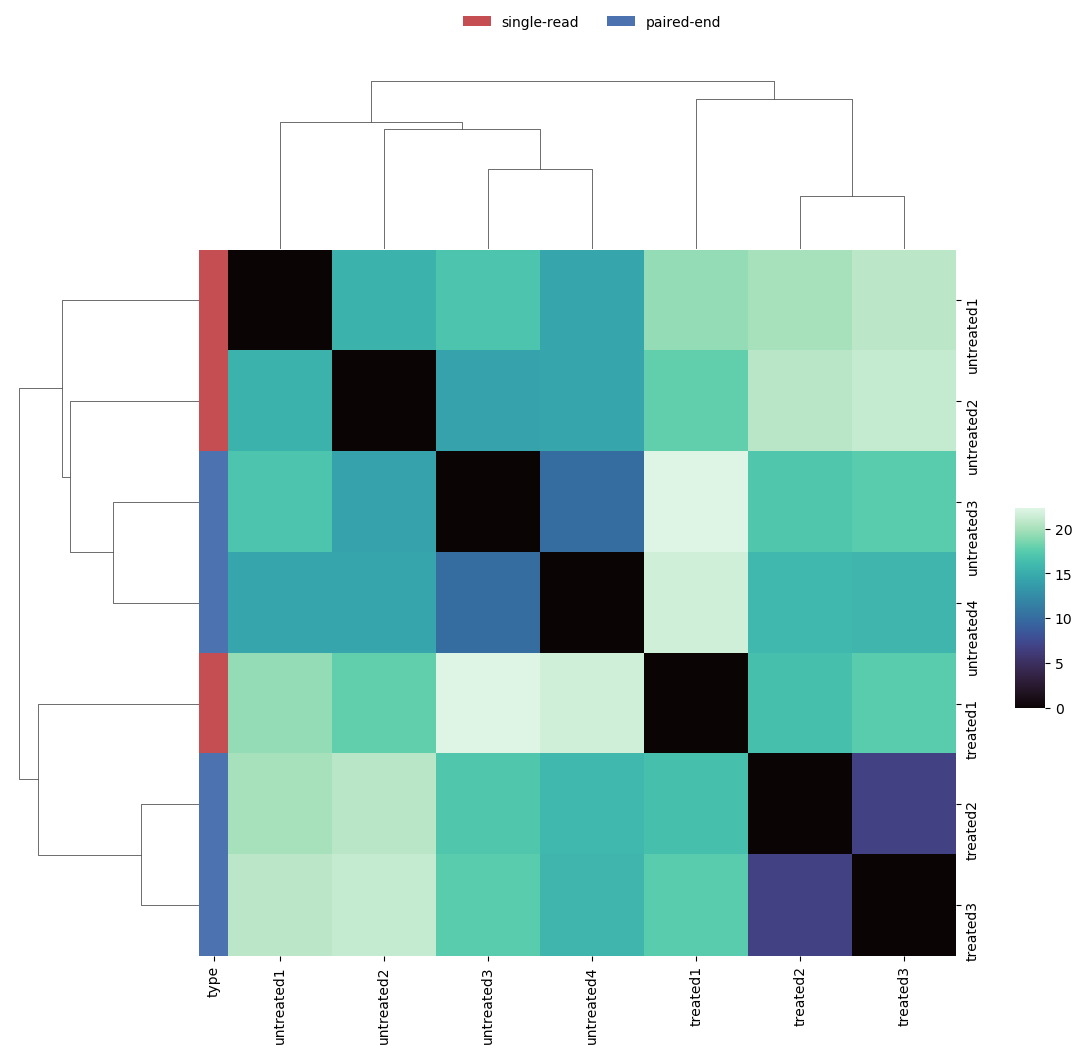

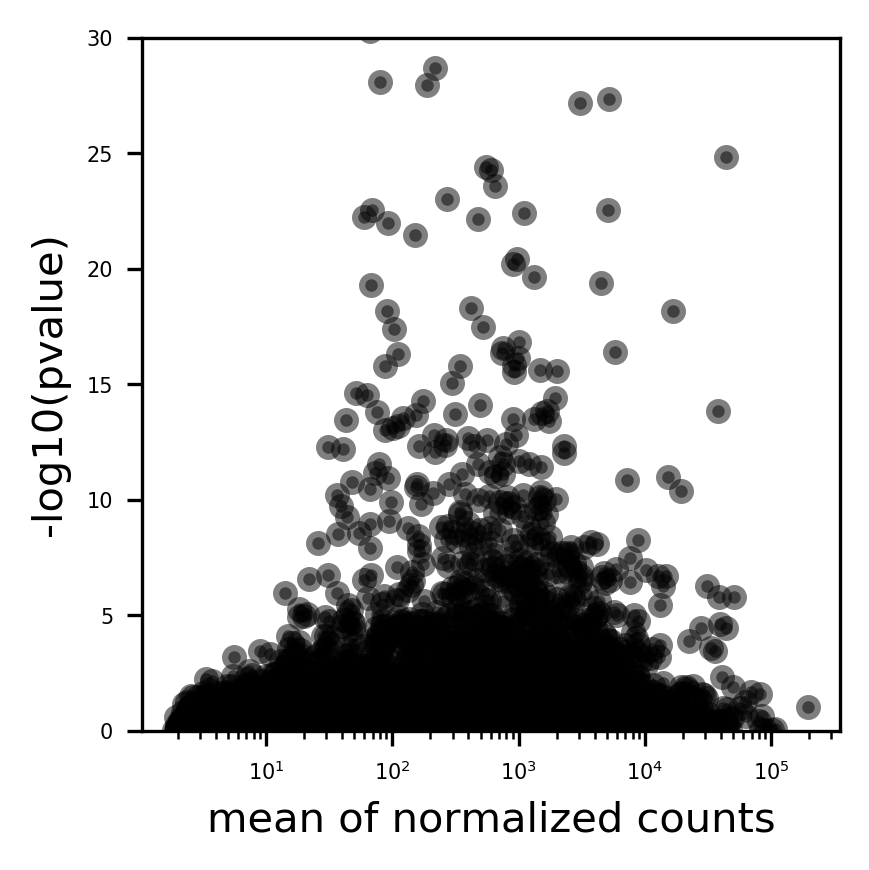

PASSED
pytest_for_deseq2.py::test_pyPlotMeannormCount_lg10pval[res_df1-150-0.9-3-0.5-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

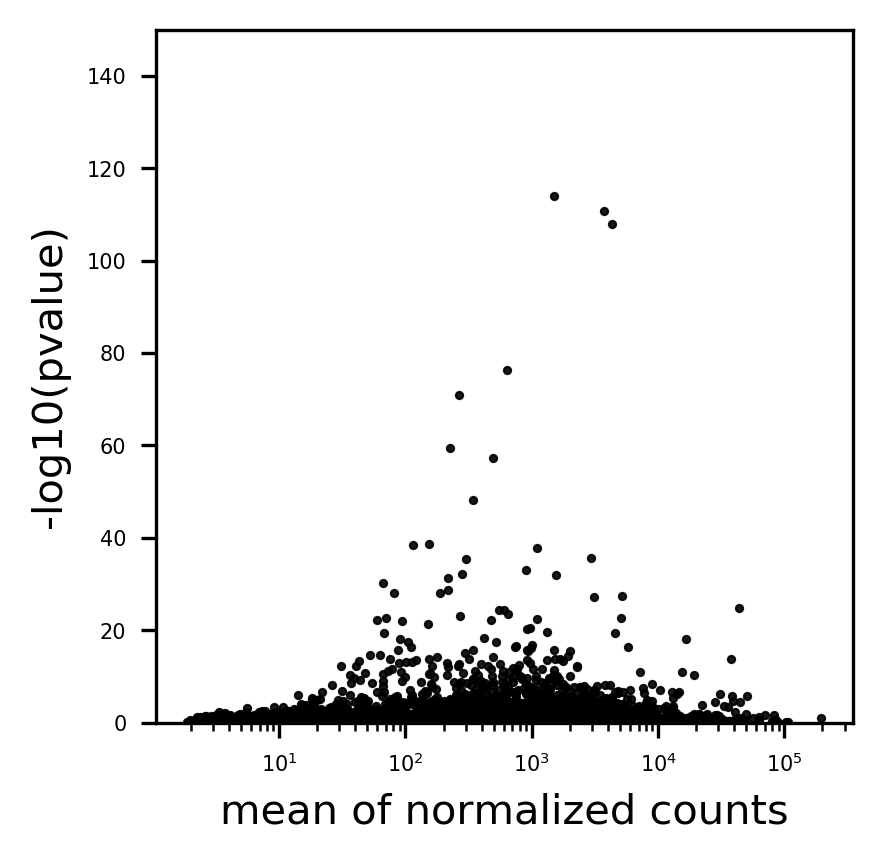

PASSED
pytest_for_deseq2.py::test_pyPlotFilterNumRej[res0-9-3-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

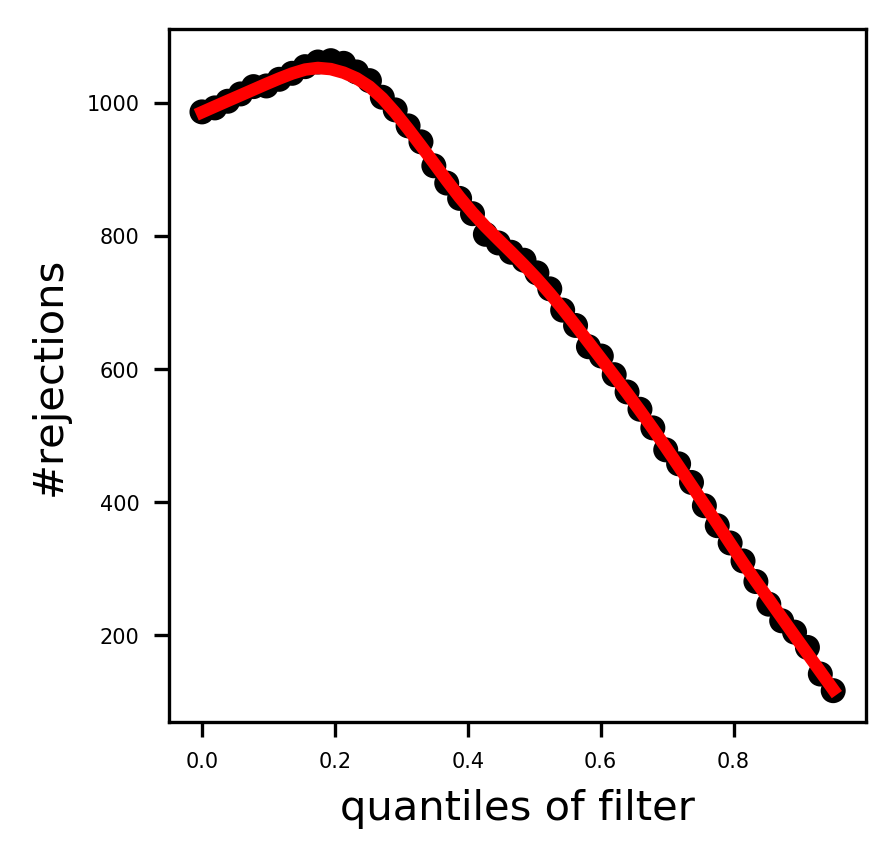

PASSED
pytest_for_deseq2.py::test_pyPlotFilterNumRej[res1-3-0.5-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

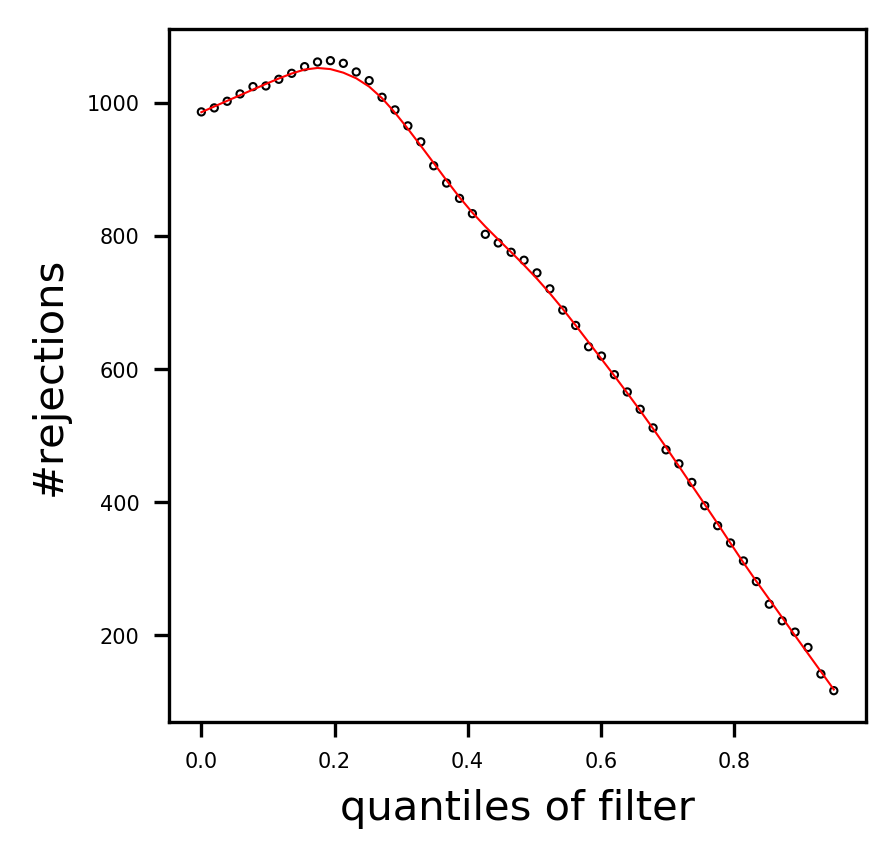

PASSED
pytest_for_deseq2.py::test_pyPlotMA[res_df0-0.1-0.7-9-3-2-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

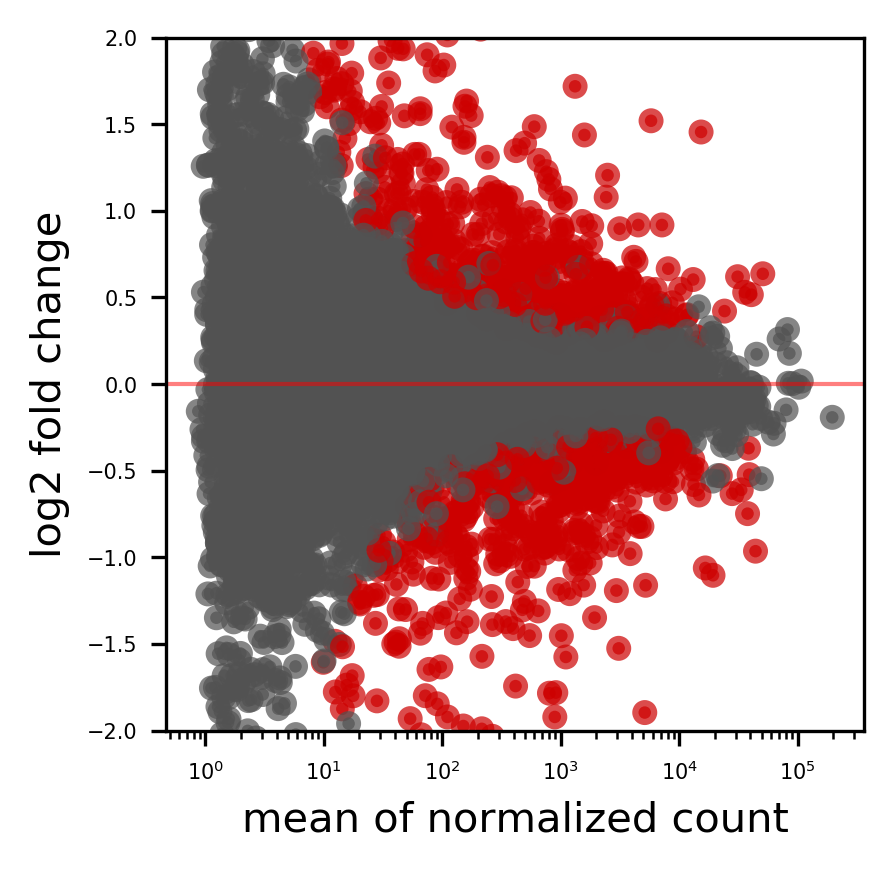

PASSED
pytest_for_deseq2.py::test_pyPlotMA[res_df1-0.5-0.9-3-0.5-4-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

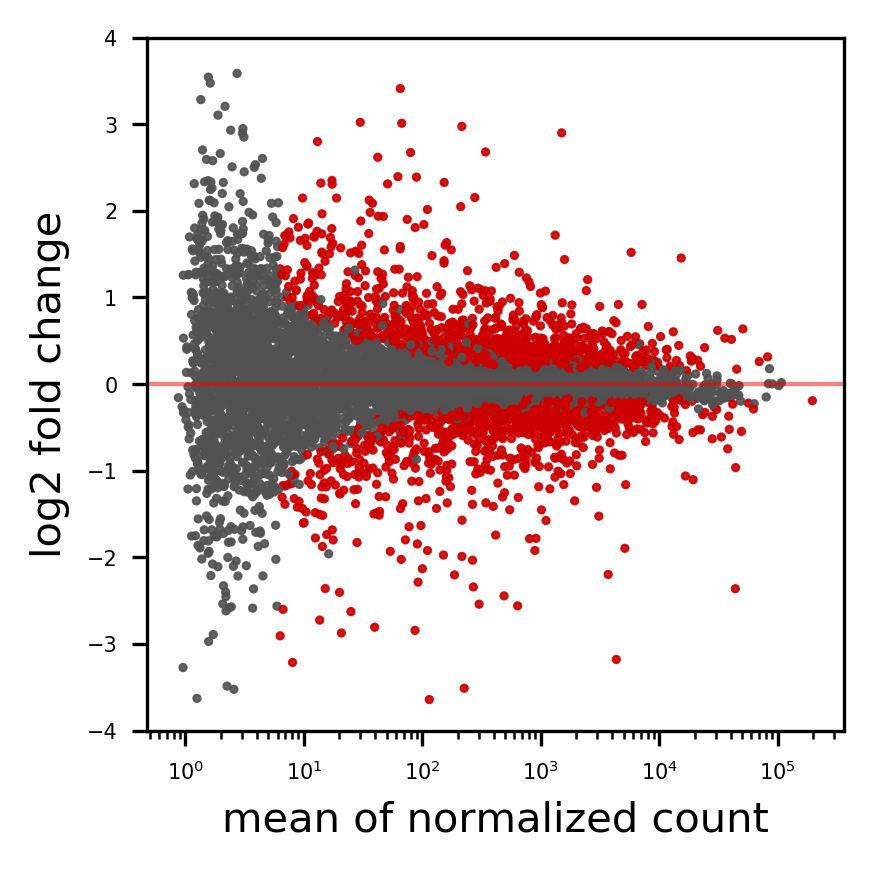

PASSED
pytest_for_deseq2.py::test_pyPlotVolcano[res_df0-0.1-0-0.7-9-3-2-2-#D90416-#033E8C-grey-save.png] <- tests/<ipython-input-8-e7f88f2790ef> 

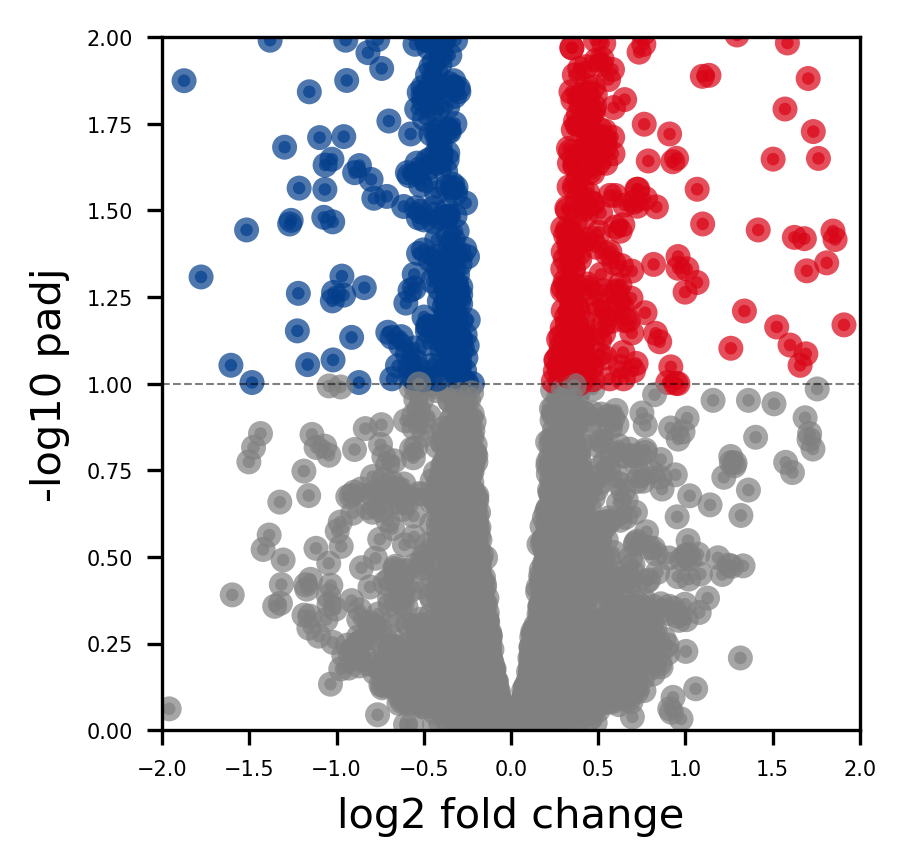

PASSED
pytest_for_deseq2.py::test_pyPlotVolcano[res_df1-0.5-1-0.9-3-0.5-2-4-#D90416-#033E8C-grey-save.pdf] <- tests/<ipython-input-8-e7f88f2790ef> 

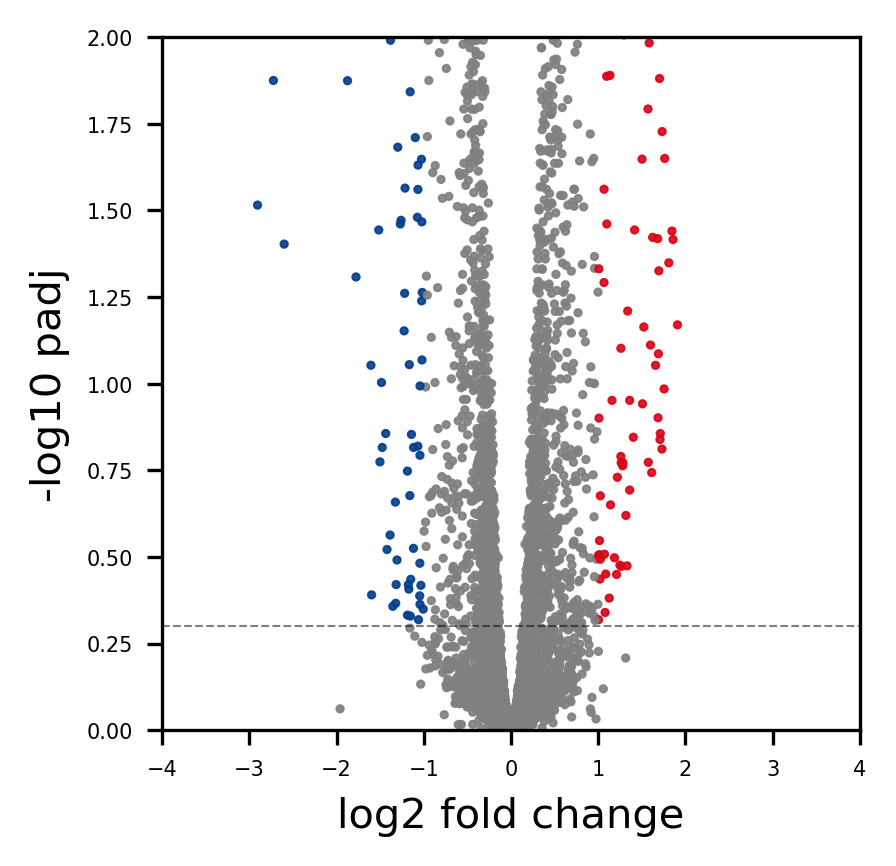

PASSED

Coverage.py warning: Module pydeseq2 was previously imported, but not measured (module-not-measured)




=============================== warnings summary ===============================
tests/pytest_for_deseq2.py::Testpydeseq2::test_pyCreateLibSizedf
  /mnt/home/gervasoni/pydeseq2/src/pydeseq2/_utils.py:187: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
    dds_counts=pd.DataFrame(np.matrix(counts(dds)), columns = colnames(dds), index=rownames(dds))

tests/pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering
tests/pytest_for_deseq2.py::test_pyPlotClustering[rld0-coldata0-None-None-save.png]
  /mnt/home/gervasoni/pydeseq2/src/pydeseq2/_plotting.py:288: UserWarning: Warning: You need to set a color condition in intgroup_name field
    warnings.warn("Warning: You need to set a color condition in intgroup_name field")

tests/pytest_for_deseq2.py::Testpydeseq2::test_pyPlotClustering
tests/py

In [9]:
ipytest.run('-svvv')